### CS282R Cluster Analysis

David Wihl  
davidwihl@g.harvard.edu




### Problem Setup

In [2]:
# general imports
%matplotlib inline
from itertools import cycle

import matplotlib.pyplot as plt
import matplotlib.colors as colors

plt.rcParams['figure.figsize'] = (8, 8)

import numpy as np
import pandas as pd
import pandas.core.algorithms as algos
from pandas import Series

from sklearn.cluster import MiniBatchKMeans

n_actions = 25
n_clusters = 750

In [3]:
df = pd.read_csv('../data/Sepsis_imp.csv')

In [4]:
# TODO - clean up data based on HW2

In [5]:
observations =   ['gender','age','elixhauser','re_admission','SOFA','SIRS','Weight_kg','GCS','HR',
                  'SysBP','MeanBP','DiaBP','Shock_Index','RR','SpO2','Temp_C','FiO2_1','Potassium',
                  'Sodium','Chloride','Glucose','BUN','Creatinine','Magnesium','Calcium','Ionised_Ca',
                  'CO2_mEqL','SGOT','SGPT','Total_bili','Albumin','Hb','WBC_count','Platelets_count',
                  'PTT','PT','INR','Arterial_pH','paO2','paCO2','Arterial_BE','Arterial_lactate','HCO3',
                  'PaO2_FiO2','output_total','output_4hourly','sedation','mechvent','rrt']
# Per homework, 'sedation','mechvent','rrt' are considered observations, not interventions.
interventions = ['cumulated_balance_tev','max_dose_vaso']

results = ['died_in_hosp','mortality_90d']

X = df[observations]


In [6]:

mbk = MiniBatchKMeans(init='k-means++', n_clusters=n_clusters, batch_size=100,
                      n_init=10, max_no_improvement=10, verbose=0, init_size=3*n_clusters,
                      random_state=0)
mbk.fit(X)
mbk_means_labels_unique = np.unique(mbk.labels_)



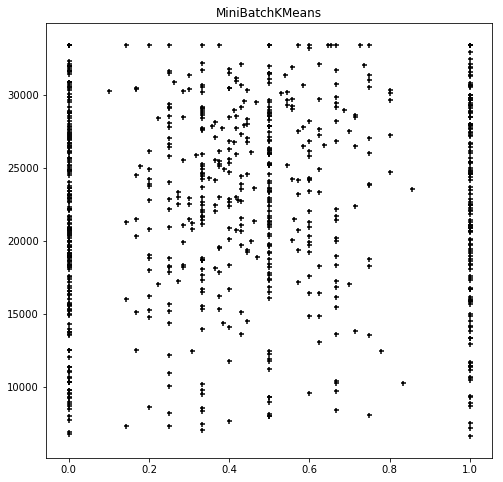

In [7]:
colors_ = cycle(colors.cnames.keys())

fig = plt.figure()
fig.subplots_adjust(left=0.04, right=0.98, bottom=0.1, top=0.9)

ax = plt.subplots()
for this_centroid, k, col in zip(mbk.cluster_centers_,
                                 range(n_clusters), colors_):
    mask = mbk.labels_ == k
#    plt.scatter(X.loc[mask, 'SysDP'], X.loc[mask, 'DiaBP'], marker='.',
#                c='w', edgecolor=col, alpha=0.5)
    plt.scatter(this_centroid[0], this_centroid[1], marker='+',
               c='k', s=25)
plt.title("MiniBatchKMeans")
plt.show()

In [8]:
# Because many blocs contain zero dose of vasopressor or zero dose or IV fluids, put zero 
# values into its own bin and evenly distribute the remaining values.
def non_zero_bins(s):
    out, retbins = pd.qcut(s.where(s >= 0.001),4,retbins=True,labels=False)
    retbins = np.insert(retbins,0,float('-inf'))
    return pd.cut(s,retbins,labels=False)

vaso_bins = non_zero_bins(df['max_dose_vaso'])
tev_bins = non_zero_bins(df['cumulated_balance_tev'])
print("Vasopressor bins counts:\n",vaso_bins.value_counts())
print("IV fluid bin counts:\n",tev_bins.value_counts())


Vasopressor bins counts:
 0    208663
2     12692
1     11163
4     10619
3      9067
Name: max_dose_vaso, dtype: int64
IV fluid bin counts:
 0    86623
4    41396
3    41395
2    41395
1    41395
Name: cumulated_balance_tev, dtype: int64


In [9]:
# Create the state, action, rewards table
#    State is label from the clustering
#    Action is [0..24] using vaso_bins * 5 + tev_bins. Each are in the range [0..4]
#    Reward=0 if the patient survived, 1 if the patient died either in the hospital or 90 days later
d = {'state': mbk.labels_, 'action':vaso_bins*5 + tev_bins, 'reward': df[results].sum(axis=1), 
     'bloc':df.bloc, 'id':df.icustayid }
mdp = pd.DataFrame(data = d)
episodes = mdp.sort_values(['id','bloc']).groupby('id')
mdp.head(5)


,action,bloc,id,reward,state
0,2,1,3,1,721
1,3,2,3,1,721
2,2,3,3,1,37
3,2,4,3,1,105
4,2,5,3,1,105


Setup complete.

## Bi-state Transitions

Let's look through all transitions and find the most common pairs of transitions. This is equivalent to creating bigrams when doing NLP. 

In [10]:
state_transition_count = np.zeros((n_clusters, n_clusters))

for name, transitions in episodes:
    state = transitions['state'].tolist()
    sprime = state[1:]
    for i in range(len(state)-1):
        state_transition_count[state[i],state[i+1]] += 1



In [11]:
nul_count = np.count_nonzero(state_transition_count==0.0)
print ("Number of null transitions:",nul_count, " out of ", n_clusters*n_clusters)
sparsity = 100*(1 - (n_clusters*n_clusters - nul_count) / (n_clusters*n_clusters)) 
print ("The state transitions are {0:.2f}% sparse".format(sparsity))
t_count = sorted(state_transition_count[np.nonzero(state_transition_count)],reverse=True)
print ("Total number of different transitions:",len(t_count))

Number of null transitions: 555935  out of  562500
The state transitions are 98.83% sparse
Total number of different transitions: 6565


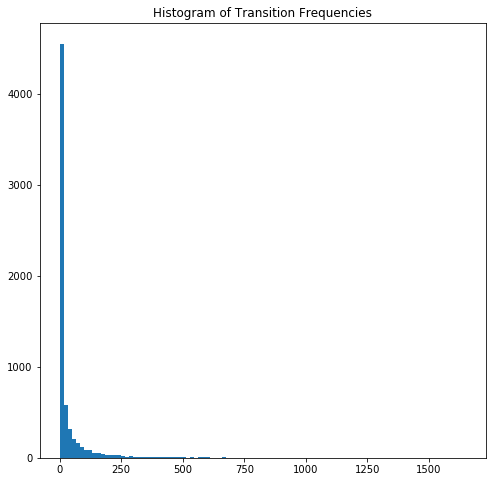

In [12]:
plt.hist(t_count,bins=100)
plt.title("Histogram of Transition Frequencies")
plt.show()

In [13]:
s = sum(t_count)
acc = 0
for i in range(len(t_count)):
    if t_count[i] < 30:
        break
    acc += t_count[i]
    if (acc / s) > 0.9:
        break
print ("The most common {0:d} transitions represent {1:.1%} of all transitions,".format(i,acc/s))
print ("which means that {0:d} other transitions are sparsely represented".format(len(t_count) - i))
print ("and have less than {0:d} total examples in the dataset.".format(int(t_count[i])))


The most common 1537 transitions represent 87.2% of all transitions,
which means that 5028 other transitions are sparsely represented
and have less than 29 total examples in the dataset.


## Next Up - Tri-state Transitions

This is the moral equivalent of tri-grams. Which triples of state transitions occur most frequently? This corresponds to a 12 hour period in the patient's history.

In [14]:
state_transition_count3 = np.zeros((n_clusters, n_clusters, n_clusters))

i =0
for name, transitions in episodes:
    state = transitions['state'].tolist()
    for i in range(len(state)-2):
        state_transition_count3[state[i],state[i+1],state[i+2]] += 1



In [15]:
nul_count3 = np.count_nonzero(state_transition_count3==0.0)
print ("Number of null transitions:",nul_count3, " out of ", n_clusters**3)
sparsity = 100*(1 - (n_clusters**3 - nul_count3) / (n_clusters**3)) 
print ("The state transitions are {0:.4f}% sparse".format(sparsity))
t_count3 = sorted(state_transition_count3[np.nonzero(state_transition_count3)],reverse=True)
print ("Total number of different transitions:",len(t_count3))

Number of null transitions: 421855241  out of  421875000
The state transitions are 99.9953% sparse
Total number of different transitions: 19759


In [16]:
s = sum(t_count3)
acc = 0
for i in range(len(t_count3)):
    if t_count3[i] < 30:
        break
    acc += t_count3[i]
    if (acc / s) > 0.9:
        break
print ("The most common {0:d} transitions represent {1:.1%} of all transitions,".format(i,acc/s))
print ("which means that {0:d} other transitions are sparsely represented".format(len(t_count3) - i))
print ("and have less than {0:d} total examples in the dataset.".format(int(t_count3[i])))


The most common 1596 transitions represent 64.4% of all transitions,
which means that 18163 other transitions are sparsely represented
and have less than 29 total examples in the dataset.


### Summary of bi-state and tri-state distributions

|Metric| Bi-state | Tri-state |
|:------|----------|-----------|
| Unique Transitions | 6565 | 19759 |
| Sparsity | 98.8% | > 99.99% |
| # Adequately Represented Transitions (>30 samples)| 1537 | 1596 |
| Percent of total transitions adequately represented| 87.2% | 64.4% |


### So what does all this mean?

When we cluster all observations into 750 different states, we end up with a very sparse set of state transitions. Of those few non-sparse remaining observed transitions, most are represented by only about 1500 different transitions irrespective of whether we consider bi-state or tri-state tuples. 

Since there are inadequate number of samples for sparsely represented transitions, we can't determine an appropriate policy and should ignore the bulk of the possible transitions.


## Doctor Variation

In [17]:
sas_count = np.zeros((n_clusters, n_actions, n_clusters))

i =0
for name, transitions in episodes:
    state = transitions['state'].tolist()
    action = transitions['action'].tolist()
    for i in range(len(state)-2):
        sas_count[state[i],action[i],state[i+1]] += 1



In [18]:
sas_nul_count = np.count_nonzero(sas_count==0.0)
print ("Number of null items:",sas_nul_count, " out of ", n_clusters*n_actions*n_clusters)
sparsity = 100*(1 - (n_clusters*n_actions*n_clusters - sas_nul_count) / (n_clusters*n_actions*n_clusters)) 
print ("The state-action-sprime matrix is {0:.2f}% sparse".format(sparsity))
distinct_sas_count = sorted(sas_count[np.nonzero(sas_count)],reverse=True)
print ("Total number of distinct state, action, sprime tuples:",len(distinct_sas_count))

Number of null items: 14027028  out of  14062500
The state-action-sprime matrix is 99.75% sparse
Total number of distinct state, action, sprime tuples: 35472


In [19]:
# Make a set of distinct actions for a given (s, s')
action_set = [[set() for i in range(n_clusters)] for j in range(n_clusters)]

for (s,a,sprime), value in np.ndenumerate(sas_count):
    if value > 0:
        # this (s, a, s') had at least one occurrance. Add the action to the set
        action_set[int(s)][int(sprime)].add(a)

    

In [20]:
# How many different actions were there for a given (s, s')
dist = []
for i in range(n_clusters):
    for j in range(n_clusters):
        # only care if there was more than one action for a given (s,s')
        if len(action_set[i][j]) > 1:
            dist.append(len(action_set[i][j]))

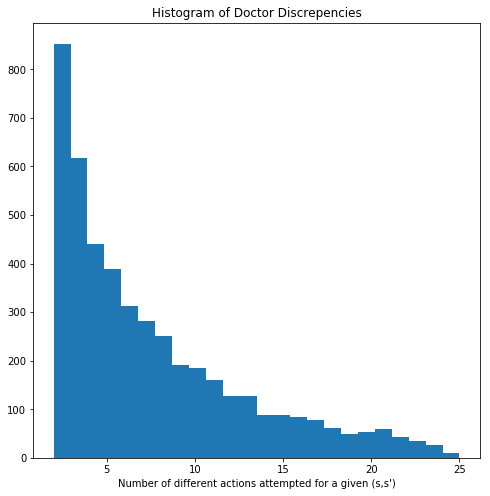

In [22]:
plt.hist(dist,bins=n_actions-1)
plt.title("Histogram of Doctor Discrepencies")
plt.xlabel("Number of different actions attempted for a given (s,s')")
plt.show()

In [156]:

print ("Out of {0:d} unique s,a,s' combinations, only {1:d} had multiple actions".format(len(distinct_sas_count),len(dist)))

Out of 35472 unique s,a,s' combinations, only 4605 had multiple actions


In [158]:
np.histogram(dist,bins=n_actions-1)

(array([853, 617, 440, 389, 312, 281, 251, 191, 184, 160, 128, 127,  89,
         88,  84,  77,  61,  49,  53,  59,  42,  34,  26,  10]),
 array([  2.        ,   2.95833333,   3.91666667,   4.875     ,
          5.83333333,   6.79166667,   7.75      ,   8.70833333,
          9.66666667,  10.625     ,  11.58333333,  12.54166667,
         13.5       ,  14.45833333,  15.41666667,  16.375     ,
         17.33333333,  18.29166667,  19.25      ,  20.20833333,
         21.16666667,  22.125     ,  23.08333333,  24.04166667,  25.        ]))

### Summary of Doctor Variation

**Bottom line: doctors tended to be consistent**. They performed the same actions for the same states, resulting 
in the same new state most of the time. 
The right tailed distribution shows that even when there were multiple actions, the number of possible different actions was small. **This is the area to explore with reinforcement learning**, as it consists of different doctor
actions for a given state, resulting in possibly different outcomes. It is not a sparse space. There are also
more than 30 different samples of different actions for the majority of (s, s') combinations.